In [26]:
import pandas as pd
import numpy as np

In [28]:
df = pd.read_csv("sofia_real_estate.csv")
df.head()

,price_total,location,property_type,square_meters,construction_type,construction_year,floor_number,floor_type
0,246255,"Малинова Долина, София",Многостаен апартамент в София,141,Тухла,2025,1 етаж,Първи жилищен
1,236305,"Бояна, София",Мезонет,134,Тухла,Not Available,Not Available,Not Available
2,239865,"Бояна, София",Тристаен апартамент в София,113,Тухла,Not Available,2 етаж,Not Available
3,160000,"Зона Б18, София",Двустаен апартамент в София,57,Тухла,2005,7 етаж,Непоследен
4,240000,"Дружба 1, София",Тристаен апартамент в София,87,ЕПК/ПК,1987,9 етаж,Непоследен


In [30]:
df.replace("Not Available", np.nan, inplace=True)

def only_digits(word):
    return "".join(ch for ch in str(word) if ch.isdigit())

num_cols_raw = ["square_meters", "construction_year", "floor_number"]
for col in num_cols_raw:
    df[col] = df[col].apply(only_digits).replace("", np.nan).astype(float)

df["location"] = df["location"].str.split(",").str[0].str.strip()
df["property_type"] = df["property_type"].str.split().str[0]

In [32]:
df["price_total"] = pd.to_numeric(df["price_total"], errors="coerce")

p99 = df["price_total"].quantile(0.99)
df = df[df["price_total"] < p99]

df = df.dropna(subset=["price_total"])

In [34]:
df.head()

,price_total,location,property_type,square_meters,construction_type,construction_year,floor_number,floor_type
0,246255.0,Малинова Долина,Многостаен,141.0,Тухла,2025.0,1.0,Първи жилищен
1,236305.0,Бояна,Мезонет,134.0,Тухла,NaN,NaN,NaN
2,239865.0,Бояна,Тристаен,113.0,Тухла,NaN,2.0,NaN
3,160000.0,Зона Б18,Двустаен,57.0,Тухла,2005.0,7.0,Непоследен
4,240000.0,Дружба 1,Тристаен,87.0,ЕПК/ПК,1987.0,9.0,Непоследен


In [36]:
df.to_csv("cleaned_sofia_real_estate.csv", index=False, encoding="utf-8")

In [40]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [42]:
num_cols = ["square_meters", "construction_year", "floor_number"]
cat_cols = ["location", "property_type", "construction_type", "floor_type"]

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", min_frequency=20))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

print("Preprocessing pipelines created")

Preprocessing pipelines created


In [44]:
X = df.drop('price_total', axis=1)
y = df['price_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data split completed:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

Data split completed:
Training set: 6340 samples
Test set: 1586 samples
Features: 7


In [46]:
models = {}
results = {}

lr_pipeline = Pipeline([
    ("prep", preprocess),
    ("reg", LinearRegression())
])
models['Linear Regression'] = lr_pipeline

rf_pipeline = Pipeline([
    ("prep", preprocess),
    ("reg", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])
models['Random Forest'] = rf_pipeline

print("Models defined:")
for name in models.keys():
    print(f"- {name}")

Models defined:
- Linear Regression
- Random Forest


In [48]:
def evaluate_model_cv(name, pipeline, X_train, y_train, cv_folds=5):
    """Evaluate model using cross-validation"""
    print(f"Evaluating {name} with Cross-Validation")
    
    cv_r2_scores = cross_val_score(pipeline, X_train, y_train, cv=cv_folds, scoring='r2')
    cv_rmse_scores = -cross_val_score(pipeline, X_train, y_train, cv=cv_folds, scoring='neg_root_mean_squared_error')
    
    print(f"Cross-Validation Results ({cv_folds}-fold):")
    print(f"R² scores: {cv_r2_scores}")
    print(f"R² mean: {cv_r2_scores.mean():.4f}")
    print(f"RMSE mean: {cv_rmse_scores.mean():.0f} EUR")
    
    return {
        'cv_r2_scores': cv_r2_scores,
        'cv_r2_mean': cv_r2_scores.mean(),
        'cv_rmse_scores': cv_rmse_scores,
        'cv_rmse_mean': cv_rmse_scores.mean()
    }

print("Cross-validation function defined")

Cross-validation function defined


In [50]:
print("Starting Linear Regression evaluation...")

lr_cv_results = evaluate_model_cv('Linear Regression', models['Linear Regression'], X_train, y_train)

models['Linear Regression'].fit(X_train, y_train)

y_pred_lr = models['Linear Regression'].predict(X_test)

lr_test_r2 = r2_score(y_test, y_pred_lr)
lr_test_rmse = root_mean_squared_error(y_test, y_pred_lr)
lr_test_mae = mean_absolute_error(y_test, y_pred_lr)

print(f"\nTest Set Results:")
print(f"R²: {lr_test_r2:.4f}")
print(f"RMSE: {lr_test_rmse:.0f} EUR")
print(f"MAE: {lr_test_mae:.0f} EUR")

results['Linear Regression'] = {
    **lr_cv_results,
    'test_r2': lr_test_r2,
    'test_rmse': lr_test_rmse,
    'test_mae': lr_test_mae,
    'predictions': y_pred_lr,
    'pipeline': models['Linear Regression']
}

Starting Linear Regression evaluation...
Evaluating Linear Regression with Cross-Validation
Cross-Validation Results (5-fold):
R² scores: [0.62967607 0.62808313 0.62867868 0.64648939 0.63904848]
R² mean: 0.6344
RMSE mean: 77377 EUR

Test Set Results:
R²: 0.6284
RMSE: 78367 EUR
MAE: 55168 EUR


In [52]:
print("Starting Random Forest evaluation...")

rf_cv_results = evaluate_model_cv('Random Forest', models['Random Forest'], X_train, y_train)

models['Random Forest'].fit(X_train, y_train)

y_pred_rf = models['Random Forest'].predict(X_test)

rf_test_r2 = r2_score(y_test, y_pred_rf)
rf_test_rmse = root_mean_squared_error(y_test, y_pred_rf)
rf_test_mae = mean_absolute_error(y_test, y_pred_rf)

print(f"\nTest Set Results:")
print(f"R²: {rf_test_r2:.4f}")
print(f"RMSE: {rf_test_rmse:.0f} EUR")
print(f"MAE: {rf_test_mae:.0f} EUR")

results['Random Forest'] = {
    **rf_cv_results,
    'test_r2': rf_test_r2,
    'test_rmse': rf_test_rmse,
    'test_mae': rf_test_mae,
    'predictions': y_pred_rf,
    'pipeline': models['Random Forest']
}

Starting Random Forest evaluation...
Evaluating Random Forest with Cross-Validation
Cross-Validation Results (5-fold):
R² scores: [0.75923095 0.79421704 0.77356906 0.75555013 0.80933409]
R² mean: 0.7784
RMSE mean: 60113 EUR

Test Set Results:
R²: 0.7866
RMSE: 59385 EUR
MAE: 36354 EUR


In [53]:
import joblib

best_pipeline = results['Random Forest']['pipeline']
joblib.dump(best_pipeline, 'best_real_estate_model.pkl')

['best_real_estate_model.pkl']

Top 10 Feature Importances:
                     feature  importance
0              square_meters    0.546536
68  property_type_Многостаен    0.087750
1          construction_year    0.050705
2               floor_number    0.048889
65    property_type_Двустаен    0.032159
25          location_Лозенец    0.032152
61           location_Център    0.029492
21    location_Кръстова Вада    0.022209
44          location_Оборище    0.016881
29          location_Люлин 5    0.009068


C:\Users\vvale\AppData\Local\Temp\ipykernel_5916\450274115.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


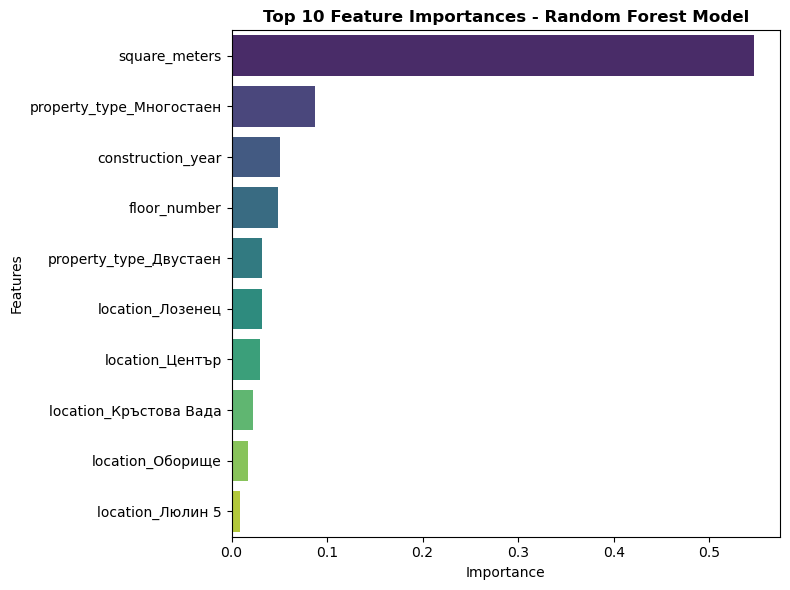

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

rf_model = best_pipeline.named_steps['reg']

preprocessor = best_pipeline.named_steps['prep']

num_feature_names = num_cols

cat_feature_names = []
ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
cat_features_encoded = ohe.get_feature_names_out(cat_cols)
cat_feature_names.extend(cat_features_encoded)

all_feature_names = num_feature_names + list(cat_feature_names)

feature_importance = pd.DataFrame({
    'feature': all_feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Feature Importances:")
print(feature_importance.head(10))

plt.figure(figsize=(8, 6))
top_features = feature_importance.head(10)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 10 Feature Importances - Random Forest Model', fontsize=12, fontweight='bold')
plt.xlabel('Importance', fontsize=10)
plt.ylabel('Features', fontsize=10)
plt.tight_layout()
plt.show()